# Imports

In [24]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

# Define image transformations

In [25]:
# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# CAM functions

In [26]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    """
    generate the class activation maps upsample to 256x256
    
    feature_conv.shape = 1x512x7x7
    weight_softmax.shape = 1000x512
    
    weight_softmax[0].shape = 1x512
    feature_conv.reshape((nc, h*w)).shape = 512x49
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
        
    # weighted sum of all feature maps
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w))) # cam.shape = 1x49
    cam = cam.reshape(h, w) # cam.shape = 7x7

    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)

    output_cam = cv2.resize(cam_img, size_upsample) # output_cam.shape = 256x256
        
    return output_cam

In [27]:
def show_cam(CAM, width, height, orig_image, class_idx, all_classes, save_name):
        heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        
        # put class label text on the result
        result = cv2.putText(result, all_classes[class_idx], (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 2)
        result = result.astype(np.float32) # Cast to float32
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        # Plot image
        plt.imshow(result/255.)
       
        # Settings
        plt.axis('off')
        plt.show()
        
        # Save output
        cv2.imwrite(f"outputs/output_{save_name}", result)
        features_blobs.clear()

In [28]:
def transform_and_forward(image, transforms,model,k):
    # apply the image transforms
    image_tensor = transforms(image).unsqueeze(0)

    # forward pass through model
    outputs = model(image_tensor)

    # get the softmax probabilities
    probs = F.softmax(outputs, dim=1).data.squeeze()

    # get the class indices of top k probabilities
    class_idx = topk(probs, k)[1].int()
    
    return class_idx, probs

In [29]:
def get_CAM_overlay(CAM, width, height, orig_image, class_idx, all_classes):
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + orig_image * 0.5

    # put class label text on the result
    #result = cv2.putText(result, all_classes[class_idx], (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 2)
    result = result.astype(np.float32) # Cast to float32
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # Convert to RGB
    result = result/255

    # Clear for next image
    features_blobs.clear()
    
    return result

# Load images

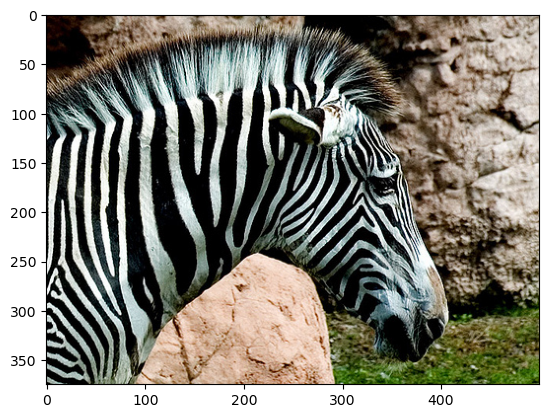

In [30]:
input_file = "zebra.jpg"

image = cv2.imread(input_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

imshow(image)

# Load Labels

In [31]:
def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            label = line.strip().split(':', 1)[1].strip(" '").split(',')[0]
            label = label.strip("'")  # Remove any remaining single quotes
            all_classes.append(label)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('labels.txt')

# Load model RESNET-18

In [32]:
# load the model
model = models.resnet18(pretrained=True).eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)

# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# Generate maps and visualize results

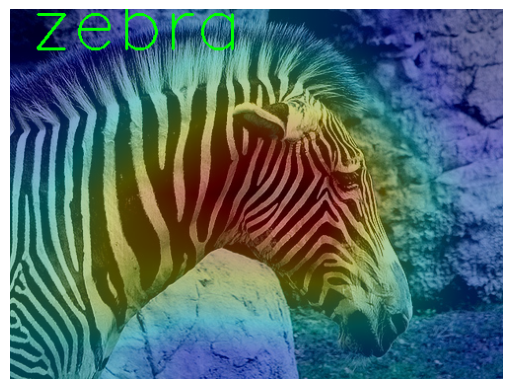

In [23]:
# Feed image
class_idx, probs = transform_and_forward(image,transforms,model,1)

# generate class activation mapping for the top1 prediction
CAM = returnCAM(features_blobs[0], weight_softmax, class_idx)

# show and save the results
show_cam(CAM, width, height, image, class_idx, all_classes, input_file)

In [12]:
top_probs, top_indices = topk(probs, 5)
top_class_names = [all_classes[idx] for idx in top_indices]
print("Top 5 class names:", top_class_names)


Top 5 class names: ['zebra', 'echidna', 'flatworm', 'tiger', 'tiger cat']
